In [1]:
import torch
import torch.nn as nn 

### Parameters

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50527, 
    "context_length": 1024, 
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

### Dummy Transformer Block

In [3]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

### Dummy GPT Model

In [4]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Tiktoken

In [5]:
import tiktoken 

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day hold a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 1745,  257]])


In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(f"Ouptut Shape: {logits.shape}")
print(logits)

Ouptut Shape: torch.Size([2, 4, 50527])
tensor([[[-0.4811,  0.4325, -0.6385,  ..., -0.9398, -0.1178,  0.1945],
         [-0.0843,  0.4519,  0.2060,  ..., -0.5766, -0.5318, -1.4576],
         [ 0.7199,  0.0575,  0.2597,  ..., -1.0028, -1.9158, -0.5157],
         [ 1.8422,  0.0252,  0.9573,  ..., -0.0315, -0.2424, -0.2487]],

        [[-0.9559,  1.3580, -0.4468,  ..., -0.5588,  0.4615, -0.3940],
         [-0.5088,  0.2881,  0.5815,  ..., -0.0353,  0.1133, -0.5654],
         [-1.1309, -0.8578,  1.3953,  ...,  1.0018, -0.7334,  0.3572],
         [ 0.6819, -0.8203,  1.2607,  ...,  1.1441, -0.7271, -2.8555]]],
       grad_fn=<UnsafeViewBackward0>)


In [7]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f'Mean: {mean}, Variance: {var}')

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>), Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [9]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode=False)
print(f"Normalized layer outputs: \n {out_norm}")
print(f"Mean: \n {mean}")
print(f"Variance: \n {var}")

Normalized layer outputs: 
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean: 
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift 

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print(f"Mean: {mean}")
print(f"Var: {var}")

Mean: tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Var: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### GELU Module

In [12]:
import math 
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x,3))))


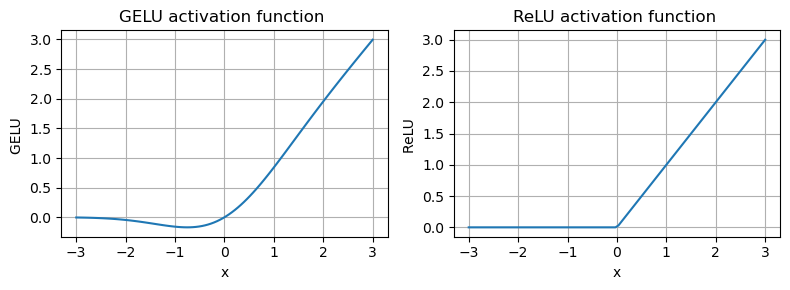

In [13]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu = gelu(x)
y_relu = relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function ")
    plt.xlabel("x")
    plt.ylabel(f"{label} ")
    plt.grid(True)
plt.tight_layout()
plt.show()




### FF Layer

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


In [15]:
ffn = FeedForward(cfg=GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out_ffn = ffn(x)
print(f"Output Shape: {out_ffn.shape}")
print(f"Output: \n {out_ffn}")




Output Shape: torch.Size([2, 3, 768])
Output: 
 tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)


### Shortcut connections

#### Illustration of shortcut connections

In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut=False):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers: 
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape: 
                x = x + layer_output
            else:
                x = layer_output
        return x

### Shortcut connection analysis

In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([0.])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name: 
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [18]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


/home/bmartins/anaconda3/envs/llm-scratch/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/bmartins/anaconda3/envs/llm-scratch/lib/python3.11/site-packages/torch/autograd/graph.py:841: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [19]:
# Testing a model with skip connections 
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


### Multi-head attention

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0) # d_out must be divisible by num_heads 
        self.d_out = d_out 
        self.num_heads = num_heads 
        self.head_dim = d_out // num_heads 
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a num_heads dimension
        # then we unroll the last dim
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose from (batch, num_tokens, num_heads, head_dim) to (batch, num_hedas, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute dot product for eqch head 
        attn_scores = queries @ keys.transpose(2, 3)
        # masks truncated to the number of tokens - set by the longest sentence in the batch
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # uses the mask to fill attention scores 
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # converting to (batch, num_tokens, n_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        # combines heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        # optional linear projection 
        context_vec = self.out_proj(context_vec)      
        return context_vec 


### Transformer blocks 

In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"], 
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"], 
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [22]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

### GPT Model

In [23]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds 
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits 

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print(f"Input batch: {batch}")
print(f"Output shape: {out.shape}")
print(out)

Input batch: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 1745,  257]])
Output shape: torch.Size([2, 4, 50527])
tensor([[[-0.4080,  1.2829,  0.1245,  ..., -0.1089,  0.3501,  1.3657],
         [-0.2078,  0.2583,  0.5438,  ..., -0.2828, -0.6319,  0.0631],
         [-0.9061, -0.0543, -0.3181,  ..., -0.5065, -0.7807,  0.1212],
         [-0.0197,  0.0990, -0.2749,  ..., -0.2600, -0.7665,  0.1369]],

        [[-0.8632,  1.1687, -0.1051,  ..., -0.1885,  0.2798,  1.1261],
         [-0.0049,  1.0500, -0.4110,  ..., -0.4031, -0.4179,  0.8799],
         [-0.6840,  0.8434,  0.1022,  ...,  0.5138,  0.5619,  0.9435],
         [ 0.4301,  0.2137, -0.6258,  ...,  0.4201, -0.3677,  0.5656]]],
       grad_fn=<UnsafeViewBackward0>)


In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params:,}')

Total number of parameters: 163,424,256


### Weight Tying

In [26]:
print(f'Token embedding layer shape: {model.tok_emb.weight.shape}')
print(f'Output layer shape: {model.out_head.weight.shape}')

Token embedding layer shape: torch.Size([50527, 768])
Output layer shape: torch.Size([50527, 768])


In [27]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Number of training parameters considering weight tying: {total_params_gpt2}")

Number of training parameters considering weight tying: 124619520


### Memory requirements

In [28]:
total_size_bytes = total_params * 4 # assuming float32 - 4 bytes per parameter 
total_size_mb = total_size_bytes / (1024 * 1024) # converts to MB
print(f"Total size of the model: {total_size_mb:.2f} MB")


Total size of the model: 623.41 MB


Output tensor: [batch_size, num_tokens, vocab_size]

In [29]:

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] #always keep the last context_size tokens 
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :] #always take the last token 
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx 


In [30]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)


encoded:  [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [31]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output: ", out)
print("Output length: ", len(out[0]))


Output:  tensor([[15496,    11,   314,   716,  5631, 32744, 22400, 49690, 33426, 15386]])
Output length:  10


In [32]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded text: ", decoded_text)

Decoded text:  Hello, I amDA REALochond assailantsの�ahn


### Pre-training on labeled data 

In [33]:
GPT_CONFIG_124M = {
    "vocab_size": 50527,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()



GPTModel(
  (tok_emb): Embedding(50527, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### Test token generation 

In [34]:
import tiktoken 

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension 
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension 
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(f"Output text: {token_ids_to_text(token_ids, tokenizer)}")


Output text: Every effort moves you551 Scriptures transient shelterperfect oil Mist invaded Gingrichctx


### Calculating text generation loss

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100], [40, 1107, 588]])
targets = torch.tensor([[3626, 6100, 345], [1107, 588, 11311]])

with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50527])


In [36]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f'Token ids: {token_ids}')

Token ids: tensor([[[23575],
         [47550],
         [ 5095]],

        [[37094],
         [16219],
         [39474]]])


In [37]:
print(f'Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}')
print(f'Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}')

Targets batch 1:  effort moves you
Outputs batch 1:  Session STA injury
